# Save annual IRF calibration data

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import datetime as dt
import glob
import os.path
from multiprocessing import Pool

import feather as ft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scmdata
import seaborn as sns
import statsmodels.api as sm
import tqdm.autonotebook as tqdman
from openscm_units import unit_registry
from patsy import dmatrices

import config

<ipython-input-2-050fe29c8a0e>:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

In [3]:
ID = config.ID

<IPython.core.display.Javascript object>

In [4]:
STITCHED_NORMALISED_DIR = "./{}-irf-calibration-crunch-stitched-normalised".format(ID)

MAX_WORKERS = 60

<IPython.core.display.Javascript object>

In [5]:
load_dir = STITCHED_NORMALISED_DIR

<IPython.core.display.Javascript object>

In [6]:
crunched_files = [
    f
    for f in glob.glob(os.path.join(load_dir, "**", "*.nc"), recursive=True)
    if "abrupt-4xCO2" in f
]
crunched_files
display(len(crunched_files))
crunched_files[:20]

8

['./20210720-irf-calibration-crunch-stitched-normalised/netcdf-scm_rsdt_Amon_ACCESS-CM2_abrupt-4xCO2_r1i1p1f1_gn_95001-109912.nc',
 './20210720-irf-calibration-crunch-stitched-normalised/netcdf-scm_rlut_Amon_ACCESS-CM2_abrupt-4xCO2_r1i1p1f1_gn_95001-109912.nc',
 './20210720-irf-calibration-crunch-stitched-normalised/netcdf-scm_rsdt_Amon_ACCESS-ESM1-5_abrupt-4xCO2_r1i1p1f1_gn_10101-25012.nc',
 './20210720-irf-calibration-crunch-stitched-normalised/netcdf-scm_tas_Amon_ACCESS-ESM1-5_abrupt-4xCO2_r1i1p1f1_gn_10101-25012.nc',
 './20210720-irf-calibration-crunch-stitched-normalised/netcdf-scm_tas_Amon_ACCESS-CM2_abrupt-4xCO2_r1i1p1f1_gn_95001-109912.nc',
 './20210720-irf-calibration-crunch-stitched-normalised/netcdf-scm_rsut_Amon_ACCESS-ESM1-5_abrupt-4xCO2_r1i1p1f1_gn_10101-25012.nc',
 './20210720-irf-calibration-crunch-stitched-normalised/netcdf-scm_rsut_Amon_ACCESS-CM2_abrupt-4xCO2_r1i1p1f1_gn_95001-109912.nc',
 './20210720-irf-calibration-crunch-stitched-normalised/netcdf-scm_rlut_Amon_AC

<IPython.core.display.Javascript object>

In [7]:
def load_file(f):
    out = force_first_year(scmdata.ScmRun.from_nc(f), new_first_year_value=1)

    return out


def force_first_year(inp, new_first_year_value=1):
    """
    Force first year of an :obj:`ScmRun` to match a given value
    """
    ts = inp.timeseries()
    first_year = inp["year"].min()
    ts.columns = ts.columns.map(
        lambda x: dt.datetime(
            x.year - first_year + new_first_year_value, x.month, x.day
        )
    )

    out = scmdata.ScmRun(ts)
    out.metadata = inp.metadata

    return out


all_dat = []
with Pool(MAX_WORKERS) as pool:
    all_dat = pool.map(load_file, crunched_files)

all_dat = scmdata.run_append(
    [scmdata.ScmRun(s.timeseries(time_axis="year-month")) for s in tqdman.tqdm(all_dat)]
)
all_dat

/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_variable(ds.variables["time"])
/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_variable(ds.variables["time"])
/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_varia

  0%|          | 0/8 [00:00<?, ?it/s]

<scmdata.ScmRun (timeseries: 3616, timepoints: 1800)>
Time:
	Start: 0001-01-16T05:00:00
	End: 0150-12-16T19:00:00
Meta:
	     activity_id  climate_model grid member_id mip_era        model  \
	0           CMIP     ACCESS-CM2   gn  r1i1p1f1   CMIP6  unspecified   
	1           CMIP     ACCESS-CM2   gn  r1i1p1f1   CMIP6  unspecified   
	2           CMIP     ACCESS-CM2   gn  r1i1p1f1   CMIP6  unspecified   
	3           CMIP     ACCESS-CM2   gn  r1i1p1f1   CMIP6  unspecified   
	4           CMIP     ACCESS-CM2   gn  r1i1p1f1   CMIP6  unspecified   
	...          ...            ...  ...       ...     ...          ...   
	3611        CMIP  ACCESS-ESM1-5   gn  r1i1p1f1   CMIP6  unspecified   
	3612        CMIP  ACCESS-ESM1-5   gn  r1i1p1f1   CMIP6  unspecified   
	3613        CMIP  ACCESS-ESM1-5   gn  r1i1p1f1   CMIP6  unspecified   
	3614        CMIP  ACCESS-ESM1-5   gn  r1i1p1f1   CMIP6  unspecified   
	3615        CMIP  ACCESS-ESM1-5   gn  r1i1p1f1   CMIP6  unspecified   
	
	             

<IPython.core.display.Javascript object>

In [8]:
def get_gregory_plot_df(inp, tas_unit="K", flux_unit="W / m^2"):
    gregory_plot_df = (
        inp.filter(region="Nearest World")
        .time_mean("AC")
        .convert_unit(tas_unit, variable="tas")
        .convert_unit(flux_unit, variable="r*")
        .drop_meta("variable_standard_name")
        .timeseries(time_axis="year")
        .reset_index("unit", drop=True)
        .unstack("variable")
        .stack("time")
    )
    gregory_plot_df["rndt"] = (
        gregory_plot_df["rsdt"] - gregory_plot_df["rsut"] - gregory_plot_df["rlut"]
    )

    return gregory_plot_df

<IPython.core.display.Javascript object>

In [9]:
def get_gregory_regression_values(gregory_plot_df, tas_unit, flux_unit):
    y, X = dmatrices("rndt ~ tas", data=gregory_plot_df, return_type="dataframe")
    mod = sm.OLS(y, X)
    res = mod.fit()

    intercept = res.params["Intercept"]
    gradient = res.params["tas"]
    lambda_val = -gradient * unit_registry(f"{flux_unit} / {tas_unit}")
    forcing_4xco2 = intercept * unit_registry(f"{flux_unit}")
    forcing_2xco2 = forcing_4xco2 / 2
    ecs = forcing_2xco2 / lambda_val

    return {
        "lambda": lambda_val,
        "rf_4xco2": forcing_4xco2,
        "rf_2xco2": forcing_2xco2,
        "ecs": ecs,
    }

<IPython.core.display.Javascript object>

In [10]:
def make_gregory_plot(
    gregory_regression_values, gregory_plot_df, tas_unit, flux_unit, ax, style=None
):
    scat_kwgs = dict(
        data=gregory_plot_df,
        y="rndt",
        x="tas",
        ax=ax,
    )
    if style is not None:
        scat_kwgs["style"] = style

    ax = sns.scatterplot(**scat_kwgs)

    ax.set_xlim(xmin=0)

    rf_4xco2 = gregory_regression_values["rf_4xco2"]
    lambda_val = gregory_regression_values["lambda"]
    #     print(ax.get_xlim())

    x_vals = np.array([0, (rf_4xco2 / lambda_val).to(tas_unit).magnitude])
    ax.set_xlim(x_vals)
    print(x_vals)
    ax.plot(
        x_vals,
        (rf_4xco2 - (lambda_val * (x_vals * unit_registry(tas_unit))))
        .to(flux_unit)
        .magnitude,
        label="Gregory regression (\n   ECS: {:.2f} \n   lambda: {:.2f} \n   rf 4xCO2: {:.2f}\n)".format(
            gregory_regression_values["ecs"],
            lambda_val,
            gregory_regression_values["rf_4xco2"],
        ),
        color="grey",
    )
    ax.legend()

    def _get_index_vals(idf, c):
        out = idf.index.get_level_values(c).unique()
        assert len(out) == 1, out

        return out[0]

    ax.set_title(
        "{} {}".format(
            _get_index_vals(gregory_plot_df, "climate_model"),
            _get_index_vals(gregory_plot_df, "member_id"),
        )
    )

    ax.set_xlabel(f"tas ({tas_unit})")
    ax.set_ylabel(f"rndt ({flux_unit})")
    ax.axhline(0, color="gray")

    return ax

<IPython.core.display.Javascript object>

0it [00:00, ?it/s]

{'lambda': 0.7399232625681157 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 6.884856221356658 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.442428110678329 <Unit('watt / meter ** 2')>,
 'ecs': 4.652412330881984 <Unit('kelvin')>}

[0.         9.30482466]


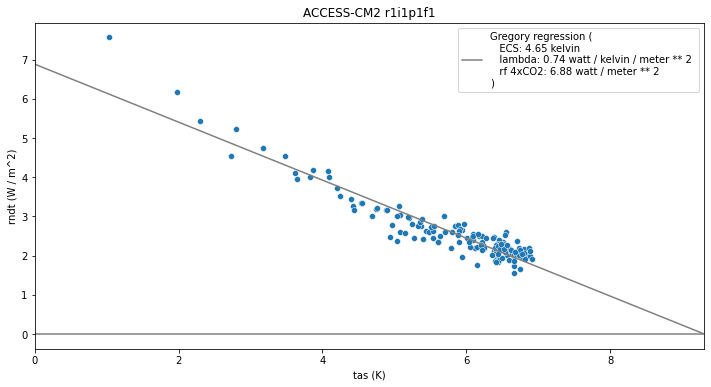

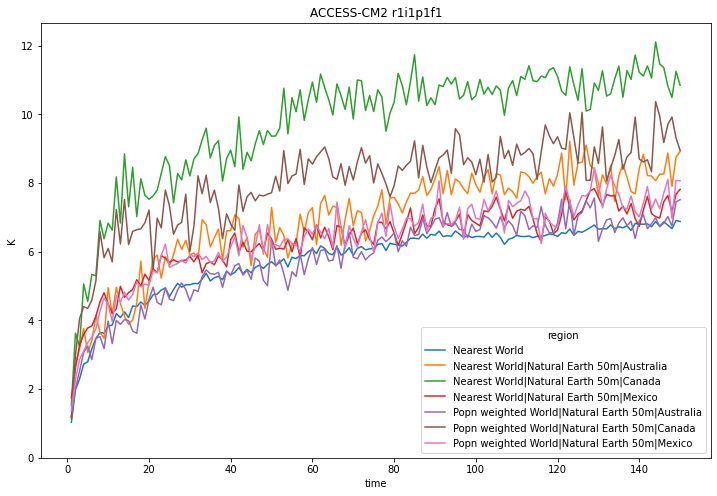

{'lambda': 0.6999582560614045 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 5.516379795030314 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 2.758189897515157 <Unit('watt / meter ** 2')>,
 'ecs': 3.9405062710956757 <Unit('kelvin')>}

[0.         7.88101254]


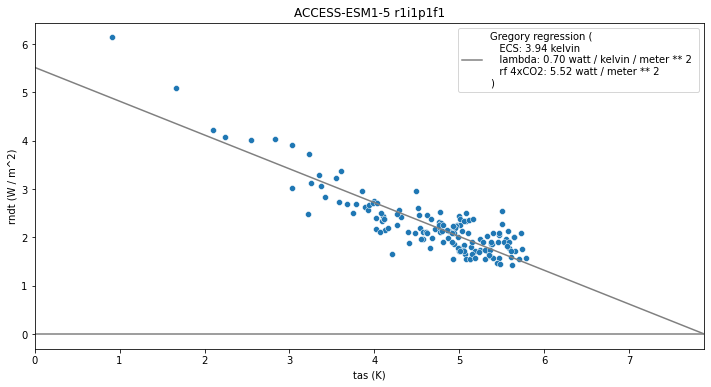

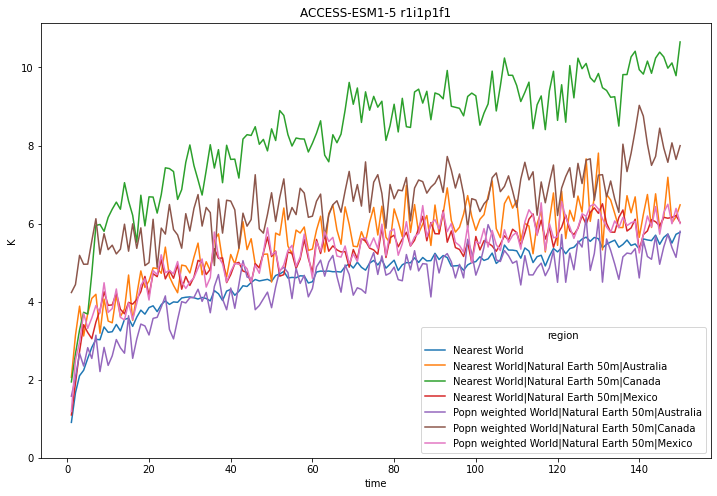

,climate_model,member_id,rf4xco2,rf4xco2_unit,ecs,ecs_unit
0,ACCESS-CM2,r1i1p1f1,6.885,W / m^2,4.652,K
1,ACCESS-ESM1-5,r1i1p1f1,5.516,W / m^2,3.941,K


<scmdata.ScmRun (timeseries: 904, timepoints: 150)>
Time:
	Start: 0001-07-01T00:00:00
	End: 0150-07-01T00:00:00
Meta:
	    activity_id  climate_model grid member_id mip_era        model  \
	0          CMIP     ACCESS-CM2   gn  r1i1p1f1   CMIP6  unspecified   
	1          CMIP     ACCESS-CM2   gn  r1i1p1f1   CMIP6  unspecified   
	2          CMIP     ACCESS-CM2   gn  r1i1p1f1   CMIP6  unspecified   
	3          CMIP     ACCESS-CM2   gn  r1i1p1f1   CMIP6  unspecified   
	4          CMIP     ACCESS-CM2   gn  r1i1p1f1   CMIP6  unspecified   
	..          ...            ...  ...       ...     ...          ...   
	899        CMIP  ACCESS-ESM1-5   gn  r1i1p1f1   CMIP6  unspecified   
	900        CMIP  ACCESS-ESM1-5   gn  r1i1p1f1   CMIP6  unspecified   
	901        CMIP  ACCESS-ESM1-5   gn  r1i1p1f1   CMIP6  unspecified   
	902        CMIP  ACCESS-ESM1-5   gn  r1i1p1f1   CMIP6  unspecified   
	903        CMIP  ACCESS-ESM1-5   gn  r1i1p1f1   CMIP6  unspecified   
	
	                           

<IPython.core.display.Javascript object>

In [15]:
tas_unit = "K"
flux_unit = "W / m^2"

rf4xco2s = []
tas_timeseries = []
for i, cm_em_scmrun in enumerate(
    tqdman.tqdm(all_dat.time_mean("AC").groupby(["climate_model", "member_id"]))
):
    climate_model = cm_em_scmrun.get_unique_meta("climate_model", True)
    member_id = cm_em_scmrun.get_unique_meta("member_id", True)

    missing_vars = {"rlut", "rsdt", "rsut", "tas"} - set(
        cm_em_scmrun.get_unique_meta("variable")
    )
    if missing_vars:
        print(f"{climate_model} {member_id} is missing data for {missing_vars}")
        continue

    gregory_plot_df = get_gregory_plot_df(
        cm_em_scmrun, tas_unit=tas_unit, flux_unit=flux_unit
    ).dropna()
    if gregory_plot_df.shape[0] < 100:
        print(f"Insufficient data for {climate_model} {member_id}")
        continue

    gregory_regression_values = get_gregory_regression_values(
        gregory_plot_df, tas_unit, flux_unit
    )
    display(gregory_regression_values)
    rf4xco2s.append(
        {
            "climate_model": climate_model,
            "member_id": member_id,
            "rf4xco2": np.round(
                gregory_regression_values["rf_4xco2"].to(flux_unit).magnitude, 3
            ),
            "rf4xco2_unit": flux_unit,
            "ecs": np.round(gregory_regression_values["ecs"].to(tas_unit).magnitude, 3),
            "ecs_unit": tas_unit,
        }
    )

    ax = plt.figure(figsize=(12, 6)).add_subplot(111)
    make_gregory_plot(
        gregory_regression_values, gregory_plot_df, tas_unit, flux_unit, ax, style=None
    )

    plt.show()

    tas_ts = cm_em_scmrun.filter(variable="tas")
    ax = plt.figure(figsize=(12, 8)).add_subplot(111)
    ax = tas_ts.filter(
        region=[
            "Nearest World",
            "Nearest World|Natural Earth 50m|Australia",
            "Popn weighted World|Natural Earth 50m|Australia",
            "Nearest World|Natural Earth 50m|Mexico",
            "Popn weighted World|Natural Earth 50m|Mexico",
            "Nearest World|Natural Earth 50m|Canada",
            "Popn weighted World|Natural Earth 50m|Canada",
        ],
    ).lineplot(ax=ax, time_axis="year", hue="region")
    ax.set_title(f"{climate_model} {member_id}")
    ax.set_ylim(ymin=0)
    plt.show()

    tas_timeseries.append(tas_ts)
#     break

rf4xco2s = pd.DataFrame(rf4xco2s)
display(rf4xco2s)
tas_timeseries = scmdata.run_append(tas_timeseries)
tas_timeseries

In [12]:
cm_u = rf4xco2s["climate_model"].unique()
display(len(cm_u))
sorted(cm_u)

2

['ACCESS-CM2', 'ACCESS-ESM1-5']

<IPython.core.display.Javascript object>

In [13]:
out_feather = "{}-irf-calibration-data-tas-timeseries.feather".format(ID)
out = tas_timeseries.timeseries(time_axis="year").reset_index()
ft.write_dataframe(out, out_feather)
!du -sh {out_feather}
rf4xco2s.to_csv("{}-irf-calibration-data-rf4xco2.csv".format(ID))

1.2M	20210720-irf-calibration-data-tas-timeseries.feather


<IPython.core.display.Javascript object>